In [1]:
%matplotlib inline


# Effect of varying threshold for self-training

This example illustrates the effect of a varying threshold on self-training.
The `breast_cancer` dataset is loaded, and labels are deleted such that only 50
out of 569 samples have labels. A `SelfTrainingClassifier` is fitted on this
dataset, with varying thresholds.

The upper graph shows the amount of labeled samples that the classifier has
available by the end of fit, and the accuracy of the classifier. The lower
graph shows the last iteration in which a sample was labeled. All values are
cross validated with 3 folds.

At low thresholds (in [0.4, 0.5]), the classifier learns from samples that were
labeled with a low confidence. These low-confidence samples are likely have
incorrect predicted labels, and as a result, fitting on these incorrect labels
produces a poor accuracy. Note that the classifier labels almost all of the
samples, and only takes one iteration.

For very high thresholds (in [0.9, 1)) we observe that the classifier does not
augment its dataset (the amount of self-labeled samples is 0). As a result, the
accuracy achieved with a threshold of 0.9999 is the same as a normal supervised
classifier would achieve.

The optimal accuracy lies in between both of these extremes at a threshold of
around 0.7.


In [4]:

# Authors: Oliver Rausch <rauscho@ethz.ch>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

n_splits = 3

X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)
scores = np.empty((x_values.shape[0], n_splits))
amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))
%whos

Variable                 Type                      Data/Info
------------------------------------------------------------
SVC                      ABCMeta                   <class 'sklearn.svm._classes.SVC'>
SelfTrainingClassifier   type                      <class 'sklearn.semi_supe<...>.SelfTrainingClassifier'>
StratifiedKFold          ABCMeta                   <class 'sklearn.model_sel<...>._split.StratifiedKFold'>
X                        ndarray                   569x30: 17070 elems, type `float64`, 136560 bytes (133.359375 kb)
X_test                   ndarray                   189x30: 5670 elems, type `float64`, 45360 bytes
X_train                  ndarray                   380x30: 11400 elems, type `float64`, 91200 bytes
accuracy_score           function                  <function accuracy_score at 0x7fa93e483790>
amount_iterations        ndarray                   14x3: 42 elems, type `float64`, 336 bytes
amount_labeled           ndarray                   14x3: 42 elems, type `f

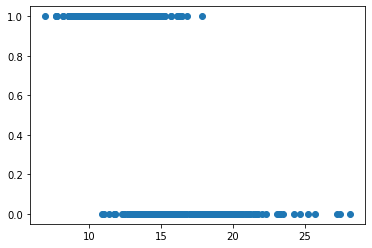

In [9]:
plt.scatter(X[:,0],y_true)

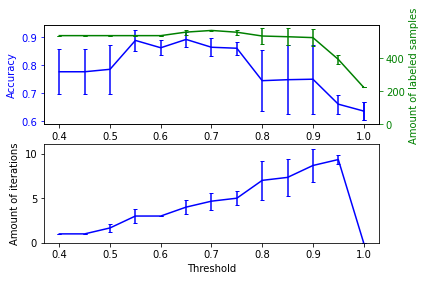

CPU times: user 23.7 s, sys: 418 ms, total: 24.1 s
Wall time: 23.8 s


In [2]:
for (i, threshold) in enumerate(x_values):
    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)

    # We need manual cross validation so that we don't treat -1 as a separate
    # class when computing accuracy
    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        # The amount of labeled samples that at the end of fitting
        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )
        # The last iteration the classifier labeled a sample in
        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)


ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="b"
)
ax1.set_ylabel("Accuracy", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="g",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Amount of labeled samples", color="g")
ax2.tick_params("y", colors="g")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="b",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Amount of iterations")
ax3.set_xlabel("Threshold")

plt.show()